# Instances and extensions

## References:

[1] https://quantum.cloud.ibm.com/learning/en/courses/variational-algorithm-design/instances-and-extensions#subspace-search-vqe-ssvqe

[2].    qiskit.primitives (https://quantum.cloud.ibm.com/docs/en/api/qiskit/primitives)

This chapter will cover several quantum variational algorithms. inclduing

*   Variational Quantum Eignesolver (VQE)
*   Subspace Search VQE (SSVQE)
*   Variational Quantum Deflation (VQD)
*   Quantum Sampling Regression (QSR)



## Variational Quantum Eigensolver (VQE)

[VQE](https://arxiv.org/abs/1304.3061) is one of the most widely used variational quantum algorithms, setting up a template for other algorithms to build upon.


<div style="text-align: center;">
    <img src="../../QuantumOpt/image_QVC/instances-vqe.svg" alt="instances-vqe" style="width: auto; height: auto;">
    <p style="font-size: 16px; font-style: italic; color: gray; margin-top: 5px;">
        High level VQE circuit overview.
    </p>
</div>

## Math layout

1.  Prepare reference opeartors $U_{R}$
    *   $|0\rangle \rightarrow |\rho\rangle$

2.  Apply the variational form $U_{V}(\vec{\theta}_{i,j})$
3.  Bootstrap at $i=0$ if we have a similar problem(typically found via classical simulation or sampling)
    *   Each optimizer will be bootstrapped differently, resulting in an initial set of parameters vectors $\Theta_{0}: = \\vec{theta}_{0,j}|j \in \mathcal{J}^{0}_{\text{opt}}$. For example, from an initial point $\vec{\theta}_0$
4.  Evaluate the cost function $C(\vec{\theta}_{i,j}): = \langle \psi(\vec{\theta}|\hat{H}|\psi(\vec{\theta}))$ for all prepared states on a quantum computer.
5.  Use a classical optimzer to select the next set of parameters $\Theta_{i+1}$.
6.  Repeast the process until covergence is reached.


Here's the example for the following observable:

$$
\hat{O}_{1} = 2II - 2 XX + 3YY - 3 ZZ
$$

C:\Users\berli\AppData\Local\Temp\ipykernel_46140\3875411322.py:14: DeprecationWarning: The class ``qiskit.circuit.library.n_local.two_local.TwoLocal`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.n_local instead.
  variational_form = TwoLocal(


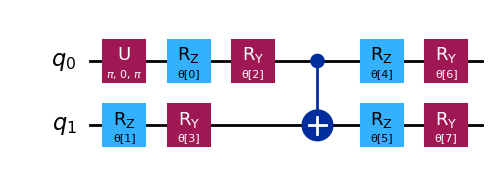

In [7]:
from qiskit import  QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import TwoLocal
import numpy as np

theta_list = (2 * np.pi *np.random.rand(1,8)).tolist()
observable = SparsePauliOp.from_list([("II",2), ("XX",-2), ("YY",3), ("ZZ",-3)])

reference_circuit = QuantumCircuit(2)
reference_circuit.x(0) # set index qubit as 1. -> |q1q0> = |10>

#reference_circuit.draw("mpl")

variational_form = TwoLocal(
    2,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1
)

ansatz= reference_circuit.compose(variational_form)
ansatz.decompose().draw("mpl")


## Define cost function

In [8]:
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator
 
    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance
 
    Returns:
        float: Energy estimate
    """

    estimator_job = estimator.run([(ansatz,hamiltonian, [params])])
    estimator_result = estimator_job.result()[0]
    
    cost = estimator_result.data.evs[0]
    return cost

In [9]:
from qiskit.primitives import StatevectorEstimator
 
estimator = StatevectorEstimator()

In [10]:
# SciPy minimizer routine
from scipy.optimize import minimize
 
x0 = np.ones(8)
 
result = minimize(
    cost_func_vqe, x0, args=(ansatz, observable, estimator), method="COBYLA"
)

result

 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -5.999999986288595
       x: [ 2.274e+00  8.371e-01  1.571e+00  1.187e-06  2.500e+00
            6.414e-01  6.336e-01  6.335e-01]
    nfev: 92
   maxcv: 0.0

## Run optimization on a real quantum compter

In [11]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import Session, EstimatorOptions
from qiskit_ibm_runtime import QiskitRuntimeService
 
 
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)
print(backend)


qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-09-14 21:54:26,381: Default instance not set. Searching all available instances.


<IBMBackend('ibm_brisbane')>


In [ ]:
### Run this optimization on a real device
"""
# Load necessary packages:
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    Session,
    EstimatorOptions,
    EstimatorV2 as Estimator,
)
from qiskit import transpile

# 1) Transpile circuit to backend’s ISA
isa_ansatz = transpile(ansatz, backend=backend, optimization_level=2,
                       layout_method="sabre", routing_method="sabre")

# 2) Align observable with the transpiled layout
isa_observable = observable.apply_layout(layout=isa_ansatz.layout)

# 3) Estimator (no Session on Open plan)
estimator = Estimator(mode=backend,
                      options=EstimatorOptions(resilience_level=1, default_shots=10000))

# 4) Use matching parameter vector length
#theta_list = np.random.rand(isa_ansatz.num_parameters).tolist()

result = minimize(
        cost_func_vqe,
        x0,
        args=(isa_ansatz, isa_observable, estimator),
        method="COBYLA",
        options={"maxiter": 200, "disp": True},
    )

print(result)
"""

'\n# Load necessary packages:\nfrom qiskit_ibm_runtime import (\n    QiskitRuntimeService,\n    Session,\n    EstimatorOptions,\n    EstimatorV2 as Estimator,\n)\nfrom qiskit import transpile\n\n# 1) Transpile circuit to backend’s ISA\nisa_ansatz = transpile(ansatz, backend=backend, optimization_level=2,\n                       layout_method="sabre", routing_method="sabre")\n\n# 2) Align observable with the transpiled layout\nisa_observable = observable.apply_layout(layout=isa_ansatz.layout)\n\n# 3) Estimator (no Session on Open plan)\nestimator = Estimator(mode=backend,\n                      options=EstimatorOptions(resilience_level=1, default_shots=10000))\n\n# 4) Use matching parameter vector length\n#theta_list = np.random.rand(isa_ansatz.num_parameters).tolist()\n\nresult = minimize(\n        cost_func_vqe,\n        x0,\n        args=(isa_ansatz, isa_observable, estimator),\n        method="COBYLA",\n        options={"maxiter": 200, "disp": True},\n    )\n\nprint(result)\n'

## Subspace Search VQE (SSVQE)

[SSVQE](https://arxiv.org/abs/1810.09434) is a variant of VQE that allows obtaining the first $k$ eigenvalues of an observable $\hat{H}$ with eigenvalues ${\lambda_{0},\lambda_{1},...,\lambda_{N-1}}$, where $N \leq k$. Without loss of generality, we assume that $\lambda_{0}<\lambda_{1}<...<\lambda_{N-1}$. SSVQE introduces a new idea by adding weights to help prioritize optimizing for the term with the largest weight.


<div style="text-align: center;">
    <img src="../../QuantumOpt/image_QVC/instances-ssvqe.svg" alt="instances-ssvqe" style="width: auto; height: auto;">
    <p style="font-size: 16px; font-style: italic; color: gray; margin-top: 5px;">
        High level SSVQE circuit overview.
    </p>
</div>

To implement this algorithm, we need $k$ mutaully orthogonal reference states ${|\rho_{j}\rangle}^{k-1}_{j=0}$, meaning $\langle \rho_{j}|\rho_{l}\rangle = \delta_{jl}$ for $j,l <k$. These states can be constructed using Pauli operators. 

The cost function of this algorithm is then:

$$
\begin{aligned}
C(\vec{\theta}) &:= \sum_{j=0}^{k-1} w_j \,\langle \rho_j \mid U_V^\dagger(\vec{\theta})\,\hat H\,U_V(\vec{\theta}) \mid \rho_j \rangle \\
                &:= \sum_{j=0}^{k-1} w_j \,\langle \psi_j(\vec{\theta}) \mid \hat H \mid \psi_j(\vec{\theta}) \rangle
\end{aligned}
$$

where $w_{j}$ is an arbitrary positive number such that if $j<l<k$ then $w_{j} > w_{l}$, and $U_{V}(\vec{\theta})$ is the user-defined variational form.


The SSVQE algorithm relies on the fact that eigenstates corresponding to different eigencalues are mutually orthogonal. Specifically, the inner product of $U_{V}(\vec{\theta})|\rho_{j}\rangle$ and $U_{V}(\vec{\theta})|\rho_{l}\rangle$ can be expressed as:

$$
\begin{aligned}
\langle \rho_j \mid U_V^\dagger(\vec{\theta})\ U_V(\vec{\theta}) \mid \rho_j \rangle & = \langle \rho_{l}|I|\rho_{l}\rangle\\
 & = \langle\rho_{j}|\rho_{l}\rangle\\
 & = \delta_{jl}
\end{aligned}

$$

The first equality holds becasue $U_{V}\vec(\theta)$ is a quantum operator and is therefore unitary. The last equality holds becasue of the orthogonality of the reference states $|\rho_{j}\rangle$. The fact that orthogonality is preserved through unitary transformations is deeply related to the principle of conservation of information, as expressed in quantum information science. Under this view, non-unitary transformations represent processes where information is either lost or injected.

**Weight $w_{j}$ helpe ensure that all the state are eigenstates.** 

*   If the weights are sufficiently different, the term with the largest weight, that is, $w_0$, will be given priority during optimization over the others. 

*   As a result, the resulting state $U_{V}(\vec{\theta})|\rho_0\rangle$ will become the eigenstate corresponding to $\lambda_0$. 

*   Since $\{U_{V}(\vec{\theta})|\rho_{j}\rangle\}^{k-1}_j=0$ are mutaully orthogonal, the remaining states will be orthogonal to it and, therefore, contained in the subspace corresponding to the eigenvalues $\{\lambda_{1},...,\lambda_{N-1}\}$.

Applying the same argument to the rest of the terms, the next priority would then be the term with weight $w_1$, so $U_{V}(\vec{\theta})|\rho_0\rangle$ would be the eigenstate correspoonding to $\lambda_1$, and the other terms would be contained in the eigenspace $\{\lambda_{2},...,\lambda_{N-1}\}$.

By reasoning inductively, we deduce that $U_{V}(\vec{\theta}|\rho_{j}\rangle)$ will be and approximate eigenstate of $\lambda_{j}$ for $0\leq j < k$

## Math layout

SSVQE's can be summarized as follows:

- **Prepare several reference states** by applying a unitary $U_R$ to $k$ different computational basis states  

  - This algorithm requires the usage of $k$ mutually orthogonal reference states $\{ \lvert \rho_j \rangle \}_{j=0}^{k-1}$,  
    such that $\langle \rho_j \mid \rho_l \rangle = \delta_{jl}$ for $j,l < k$.

- **Apply the variational form** $U_V(\vec{\theta}_{i,j})$ to each reference state, resulting in the following ansatz:  
  $$
  U_A(\vec{\theta}_{i,j})
  $$

- **Bootstrap at $i=0$** if a similar problem is available (usually found via classical simulation or sampling).

- **Evaluate the cost function**  
  $$
  C(\vec{\theta}_{i,j}) := \sum_{j=0}^{k-1} w_j \, \langle \psi_j(\vec{\theta}) \mid \hat{H} \mid \psi_j(\vec{\theta}) \rangle
  $$
  for all prepared states on a quantum computer.

  - This can be separated into calculating the expectation value for an observable  
    $\langle \psi_j(\vec{\theta}) \mid \hat{H} \mid \psi_j(\vec{\theta}) \rangle$  
    and multiplying that result by $w_j$.
  - Afterward, the cost function returns the sum of all weighted expectation values.

- **Use a classical optimizer** to determine the next set of parameters $\vec{\Theta}_{i+1}$.

- **Repeat** the above steps until convergence is achieved.




## build cost function

In [13]:
import numpy as np

def cost_func_ssvqe(
    params, initialized_ansatz_list, weights, ansatz, hamiltonian, estimator
):
    # """Return estimate of energy from estimator
 
    # Parameters:
    #     params (ndarray): Array of ansatz parameters
    #     initialized_ansatz_list (list QuantumCircuit): Array of initialised ansatz with reference
    #     weights (list): List of weights
    #     ansatz (QuantumCircuit): Parameterized ansatz circuit
    #     hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
    #     estimator (Estimator): Estimator primitive instance
 
    # Returns:
    #     float: Weighted energy estimate
    # """
    energies = []

    # Build circuits: for each |ρ_j>, apply U_V(θ)
    for ref in initialized_ansatz_list:
        # Apply U_V(θ) after reference state |ρ_j>
        circ = ref.compose(ansatz)
        job = estimator.run([(circ, hamiltonian, [params])])
        result = job.result()[0]             # first (and only) element
        ev = result.data.evs                 # expectation value(s)
        energies.append(float(np.atleast_1d(ev)[0]))

    weighted_energy_sum = float(np.dot(weights, energies))
    return weighted_energy_sum



In [14]:
from qiskit.primitives import StatevectorEstimator
 
estimator = StatevectorEstimator()

In [15]:
# ----- SSVQE bits -----

# 1) Build k orthogonal reference states (you can keep |10>, but add a few more)
refs = []
# |00>
qc00 = QuantumCircuit(2); refs.append(qc00)
# |01>
qc01 = QuantumCircuit(2); qc01.x(1); refs.append(qc01)
# |10>  (your original)
qc10 = QuantumCircuit(2); qc10.x(0); refs.append(qc10)
# |11>
qc11 = QuantumCircuit(2); qc11.x(0); qc11.x(1); refs.append(qc11)

# choose how many to use (<= 4 for 2 qubits)
initialized_ansatz_list = refs[:3]  # e.g., use 3 states

# 2) Weights (one per ref) — prioritize ground state
weights = np.array([1.0, 0.5, 0.25], float)[:len(initialized_ansatz_list)]


In [16]:
# SciPy minimizer routine
from scipy.optimize import minimize
from qiskit.primitives import StatevectorEstimator
 
estimator = StatevectorEstimator()

# 5) Optimize
num_params = len(variational_form.parameters)
x0 = np.array(theta_list[0][:num_params], float)   # or np.zeros(num_params)

res = minimize(
    cost_func_ssvqe,
    x0,
    args=(initialized_ansatz_list, weights, variational_form, observable, estimator),
    method="COBYLA",
)

print("SSVQE optimum (weighted):", res.fun)
print("best θ:", res.x)

 
result

SSVQE optimum (weighted): -2.9999999916577647
best θ: [ 6.73251237e+00  1.11644523e+00  4.71235437e+00  3.14158611e+00
  4.71236477e+00  4.71235613e+00 -1.00586516e-04  3.14152194e+00]


 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -5.999999986288595
       x: [ 2.274e+00  8.371e-01  1.571e+00  1.187e-06  2.500e+00
            6.414e-01  6.336e-01  6.335e-01]
    nfev: 92
   maxcv: 0.0

## Variational Quantum Deflation (VQD)

**VQD** extends the Variational Quantum Eigensolver (VQE) to compute not only the ground state (lowest eigenvalue) but also excited states of a Hamiltonian.

- **Problem:** Standard VQE finds only the lowest eigenvalue λ₀.  
- **Solution:** VQD introduces a **penalty term** to enforce orthogonality with previously found eigenstates, so that successive runs converge to $\lambda_{1}, \lambda_{2},...$


<div style="text-align: center;">
    <img src="../../QuantumOpt/image_QVC/instances-vqd.svg" alt="instances-vqd" style="width: auto; height: auto;">
    <p style="font-size: 16px; font-style: italic; color: gray; margin-top: 5px;">
        High level VQD circuit overview.
    </p>
</div>

### Cost Function
For the $k$-th eigenvalue:

$$
C_k(\vec{\theta}) = 
\langle \psi(\vec{\theta})|\hat H|\psi(\vec{\theta})\rangle
+ \sum_{j=0}^{k-1} \beta_j 
|\langle \psi(\vec{\theta})|\psi(\vec{\theta}_j)\rangle|^2
$$

-   First term = usual VQE expectation value.  
-   Second term = penalty to push the new state orthogonal to previously found states.  
-   $\beta_{j}$ = positive constants controlling the penalty strength.


### Algorithm Steps

1.  Run VQE $\rightarrow$ obtain ground state $\lambda_{0}$ and $|\psi({\theta_{0}})\rangle$.  
2.  Add penalty for $|\psi({\theta_{0}})\rangle$ $\rightarrow$ run again $\rightarrow$ obtain $\lambda_{1}$.
3.  Repeat with penalties for all previously found states to obtain higher eigenvalues $\lambda_{2}, \lambda_{3},...$

### Notes
-   VQD requires running VQE **k times** to obtain $k$ eigenvalues.  
-   Efficient when a small number of low-lying excited states are needed.  
-   Provides a hybrid, variational approach compared to Quantum Phase Estimation.


For example, $C_{1}(\vec{\theta}): = C_{0}(\vec{\theta}) + \beta_0 |\langle \psi(\vec{\theta})|\psi(\vec{\theta}^0)\rangle|^2 $

Alternatively, this new problem can be intrepreted as running VQE on the new observable:

$$
\hat H_1 \ := \hat H\ + \beta_{0}|\psi(\vec{\theta^{0}})\rangle\langle \psi(\vec{\theta^{0}})| \quad \Rightarrow \quad C_{1}(\vec{\theta}) = \langle \psi(\vec{\theta})|\hat{H_{1}}|\psi(\vec{\theta})\rangle
$$

Assuming that the solution to the new problem is $|\psi(\vec{\theta^{1}})\rangle$, the expected value of $\hat{H}$ (not $\hat{H}_{1}$) should be 

$$
\langle \psi(\vec{\theta^{1}})|\hat{H}|\psi(\vec{\theta^{1}})\rangle = \lambda_1
$$

To the eigenvalue $\lambda_{2}$, we can use the previous analogy,

$$
\hat H_2 \ := \hat{H}_{1} + \beta_{1}|\psi(\vec{\theta^{1}})\rangle\langle \psi(\vec{\theta^{1}})| \quad \Rightarrow \quad C_{2}(\vec{\theta}) = \langle \psi(\vec{\theta})|\hat{H_{2}}|\psi(\vec{\theta})\rangle
$$

Assuming that the solution to the new problem is $|\psi(\vec{\theta^{2}})\rangle$, the expected value of $\hat{H}$ (not $\hat{H}_{2}$) should be 

$$
\langle \psi(\vec{\theta^{2}})|\hat{H}|\psi(\vec{\theta^{2}})\rangle = \lambda_2
$$

Therefore, to obtain the $k$-th eigenvalue $\lambda_{k-1}$, you would minimize the cost function:

$$
C_{k-1}(\vec{\theta}) := C_{k-2}(\vec{\theta}) + \beta_{k-2}|\langle \psi(\vec{\theta})|\psi(\vec{\theta}^{k-2})|^{2}.
$$

*   We defined $\vec{\theta}^{j}$ such that $\langle \psi(\vec{\theta}^{j})|\hat{H}|\psi(\vec{\theta}^{j})\rangle = \lambda_{j}, \forall j < k$.
*   The problem is equivalent to minimizing $C(\vec{\theta}) = \langle \psi(\vec{\theta})|\hat{H}|\psi(\vec{\theta})\rangle$ but with the constraint that the state must be orthogonal to $|\psi(\vec{\theta^{j}})$; $\forall j \in 0,..., k-1$, thereby restricting the search space to the subspace corresponding to the eigenvalues $\{\lambda_{k-1},...,\lambda_{N-1}\}$.

For the $k$-th eigenvalue:

$$
C_k(\vec{\theta}) = 
\langle \psi(\vec{\theta})|\hat H|\psi(\vec{\theta})\rangle
+ \sum_{j=0}^{k-1} \beta_j 
|\langle \psi(\vec{\theta})|\psi(\vec{\theta}^j)\rangle|^2
$$

## How VQD Finds Excited States

- The eigenstates of a Hermitian operator (like a Hamiltonian) are always **orthogonal**.  
- Standard VQE finds only the **lowest eigenstate** (ground state, λ₀).  
- To get the next eigenstate (λ₁), the trial state must be **orthogonal** to λ₀.  
- **VQD adds a penalty term (β)**: if the trial state overlaps with λ₀, the cost increases, forcing the optimizer away from it.  
- This restricts the search to the **remaining subspace** {λ₁, λ₂, …}.  
- By the **variational principle**, the lowest eigenvalue in that subspace is λ₁, giving the first excited state.  

👉 In plain words: VQD “pushes you away” from states already found, so the optimizer naturally lands on the next excited state.


## Theoretical Layout of VQD

The Variational Quantum Deflation (VQD) procedure can be summarized as follows:

- **Prepare a reference state** using operator $U_R$.  
- **Apply a variational form** $U_V(\vec{\theta}_{i,j})$ to the reference state, producing the ansatz $U_A(\vec{\theta}_{i,j})$.  
- **Bootstrap initialization:** set $i = 0$ if a similar problem (from classical simulation or sampling) provides a good starting point.  
- **Evaluate the cost function** $C_k(\vec{\theta})$, which requires computing up to $k$ excited states and an array of penalty factors $\beta_j$:  
  - Calculate the expectation value:  
    $$
    \langle \psi_j(\vec{\theta})|\hat H|\psi_j(\vec{\theta})\rangle
    $$  
  - Calculate the penalty term:  
    $$
    \sum_{j=0}^{k-1} \beta_j \, |\langle \psi(\vec{\theta})|\psi(\vec{\theta}_j)\rangle|^2
    $$  
  - The full cost function is the sum of these two terms.  
- **Optimize classically**: use a classical optimizer to select the next parameter set $\vec{\theta}_{i+1}$.  
- **Repeat** the process until convergence is reached.


C:\Users\berli\AppData\Local\Temp\ipykernel_46140\3725103219.py:3: DeprecationWarning: The class ``qiskit.circuit.library.n_local.two_local.TwoLocal`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.n_local instead.
  ansatz = TwoLocal(2, rotation_blocks=["ry", "rz"], entanglement_blocks="cz", reps = 1)


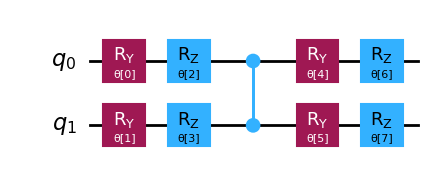

In [17]:
from qiskit.circuit.library import TwoLocal

ansatz = TwoLocal(2, rotation_blocks=["ry", "rz"], entanglement_blocks="cz", reps = 1)

ansatz.decompose().draw("mpl")

First, we will set up a function that claculates the state fidelity -- a percentage of overlap between two states that we will use as a penality for VQD.

The overlap bewteen two states: 

$$
F = |\langle\psi|\phi\rangle|^{2}.
$$

This inner product detemines how similar two states are (1 = identical, 0 = orthogonal).



In [18]:
import numpy as np
 
 
def calculate_overlaps(ansatz, prev_circuits, parameters, sampler):
    def create_fidelity_circuit(circuit_1, circuit_2):
        """
        Constructs the list of fidelity circuits to be evaluated.
        These circuits represent the state overlap between pairs of input circuits,
        and their construction depends on the fidelity method implementations.

        Construct a quantum circuit to test the overlap (fidelity) between two states.
        """
 
        if len(circuit_1.clbits) > 0:
            circuit_1.remove_final_measurements()
        if len(circuit_2.clbits) > 0:
            circuit_2.remove_final_measurements()
 
        circuit = circuit_1.compose(circuit_2.inverse())
        circuit.measure_all()
        return circuit
 
    overlaps = []
 
    for prev_circuit in prev_circuits:
        fidelity_circuit = create_fidelity_circuit(ansatz, prev_circuit)
        sampler_job = sampler.run([(fidelity_circuit, parameters)])
        meas_data = sampler_job.result()[0].data.meas
 
        counts_0 = meas_data.get_int_counts().get(0, 0)
        shots = meas_data.num_shots
        overlap = counts_0 / shots
        overlaps.append(overlap)
 
    return np.array(overlaps)

It's time to write VQD's cost function. As before when we calculated only the ground state, we will determine the lowest energy state using the Estimator primitive. However, as described above, we will now add a penalty term to ensure orthogonality of higher-energy states. That is, for each new excited state, a penalty is added for any overlap between the current variational state and the lower-energy eigenstates already found.

In [19]:
def cost_func_vqd(
    parameters, ansatz, prev_states, step, betas, estimator, sampler, hamiltonian
):
    
    # Regular VQE cost function 
    estimator_job = estimator.run([(ansatz, hamiltonian, [parameters])])
 
    total_cost = 0
    
    # if we are not looking for the ground state, add penalty terms for previous states
    if step > 1:
        overlaps = calculate_overlaps(ansatz, prev_states, parameters, sampler)
        total_cost = np.sum(
            [np.real(betas[state] * overlap) for state, overlap in enumerate(overlaps)]
        )
 
    estimator_result = estimator_job.result()[0]
    
    # add penalty to the energy with regualar VQE cost
    value = estimator_result.data.evs[0] + total_cost
 
    return value

Note especially that the cost function above refers to the `calculate_overlaps` function, which actually creates a new quantum circuit. If we want to run on real hardware, that new circuit must also be transpiled, hopefully in an optimal way, to run on the backend we select. Note that transpilation has been built in to the `calculate_overlaps` or `cost_func_vqd` functions.

In [20]:
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit.primitives import StatevectorSampler as Sampler

sampler = Sampler()
estimator = Estimator()

We will introduce an observable to be estimated. It may be helpful to think of this observable as the Hamiltonian of a system that can have excited states, even though this observable has not been chosen to match any particular molecule or atom.

In [21]:
from qiskit.quantum_info import SparsePauliOp
 
observable = SparsePauliOp.from_list([("II", 2), ("XX", -2), ("YY", 3), ("ZZ", -3)])

*   Here, we set the total number of states we wish to calculate (ground state and excited states, k), and the penalties (betas) for overlap between statevectors that should be orthogonal. 
*   The consequences of choosing betas to be too high or too low will be explored a bit in the next lesson.

In [22]:
k = 3
betas = [33, 33, 33]
x0 = np.zeros(8) # the number of parameters in your ansatz.

In [23]:
from scipy.optimize import minimize
 
prev_states = []
prev_opt_parameters = []
eigenvalues = []
 
for step in range(1, k + 1):
    if step > 1:
        prev_states.append(ansatz.assign_parameters(prev_opt_parameters))
 
    result = minimize(
        cost_func_vqd,
        x0,
        args=(ansatz, prev_states, step, betas, estimator, sampler, observable),
        method="COBYLA",
        options={
            "maxiter": 200,
        },
    )
    print(result)
 
    prev_opt_parameters = result.x
    eigenvalues.append(result.fun)

 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -5.9999999866174205
       x: [ 1.571e+00 -1.571e+00 -6.769e-01 -4.152e-01 -6.132e-01
            1.106e+00  4.623e-02  7.304e-01]
    nfev: 177
   maxcv: 0.0
 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: 4.01721872032553
       x: [ 1.660e+00  1.517e+00  1.846e-01 -1.171e+00  1.246e+00
            1.572e-01  1.483e+00 -1.995e-01]
    nfev: 95
   maxcv: 0.0
 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: 14.211129023628597
       x: [ 9.735e-20 -1.871e-18 -2.028e-18  1.049e+00  1.130e-02
            5.407e-18  0.000e+00  0.000e+00]
    nfev: 62
   maxcv: 0.0


## Quantum Sampling Regression (QSR)


<div style="text-align: center;">
    <img src="../../QuantumOpt/image_QVC/instances-qsr.svg" alt="instances-qsr" style="width: auto; height: auto;">
    <p style="font-size: 16px; font-style: italic; color: gray; margin-top: 5px;">
        High level VQD circuit overview.
    </p>
</div>

**Motivation:**  

One of the main issues with **VQE** is the need for *multiple iterative calls* to a quantum computer.  
- At each optimization step, the algorithm evaluates the cost function for a new set of parameters ($\vec{\theta}_k, \vec{\theta}_{k-1}, \dots$).  
- This means sending circuits to the quantum device **thousands of times**, waiting for results, and then updating parameters on the classical side.  
- On real hardware, these jobs often sit in a **queue**, where wait times can exceed actual execution times, making large-scale studies impractical.  

While a **Session** can group several calls together, it doesn’t eliminate the need for repeated quantum-classical communication.  

**Quantum Sampling Regression (QSR)** offers an alternative:  
- Perform **one large quantum sampling call**, then reconstruct the cost function classically.  
- This shifts most of the workload to classical resources, which are plentiful and fast, while still leveraging quantum measurements for the “hard part.”  

Since today’s quantum hardware is a **low-supply / high-demand commodity**, this trade-off is both possible and convenient. QSR allows researchers to move past the bottleneck of queueing while still preserving key quantum properties that cannot be simulated efficiently on classical machines.

**Key Idea:**  
-   The cost function

    $$
    C(\vec{\theta}) = \langle \psi(\vec{\theta})|\hat H|\psi(\vec{\theta})\rangle
    $$

    can be expressed as a **Fourier series** in the parameters.  

    $$
    C(\vec{\theta}) = a_{0} + \sum_{k=1}^{S}[a_{k}\text{cos}(k\theta) + b_{k}\text{sin}(k\theta)]
    $$

    Set $S$ may be finite or infinate depends on periodicity and bandwidth of the origainl funciton.

-   By sampling $C(\vec{\theta})$ at a finite number of parameter values, we can reconstruct the Fourier coefficients and approximate the function.  

    When we sample the cost function for $2S+1$ parameter values 
    $\{\theta_1, \ldots, \theta_{2S+1}\}$,  
    we can set up the following system to recover the Fourier coefficients:

    $$
    \begin{bmatrix}
    1 & \cos(\theta_1) & \sin(\theta_1) & \cos(2\theta_1) & \cdots & \sin(S\theta_1) \\
    1 & \cos(\theta_2) & \sin(\theta_2) & \cos(2\theta_2) & \cdots & \sin(S\theta_2) \\
    \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
    1 & \cos(\theta_{2S+1}) & \sin(\theta_{2S+1}) & \cos(2\theta_{2S+1}) & \cdots & \sin(S\theta_{2S+1})
    \end{bmatrix}
    \begin{bmatrix}
    a_0 \\ a_1 \\ b_1 \\ a_2 \\ \vdots \\ b_S
    \end{bmatrix}
    =
    \begin{bmatrix}
    C(\theta_1) \\ C(\theta_2) \\ \vdots \\ C(\theta_{2S+1})
    \end{bmatrix}.
    $$

    This system can be compactly written as:

    $$
    F a = c.
    $$

### Normalization

In practice, this system is often **not consistent** (if the equations contradict each other, so no exact solution exists.), since the cost values $c$ come from noisy quantum measurements (the equations usually don’t line up perfectly). 
To handle this, we normalize by multiplying both sides with $F^\dagger$, obtaining a least-squares formulation:

$$
F^\dagger F a = F^\dagger c.
$$

This normalized system is always consistent (if there exists at least one exact solution $a$ that satisfies all equations at once.) and provides a stable solution for the Fourier coefficients.

**Process:**  
1. Sample the cost function at $2S+1$ points per parameter to obtin the Fourier coefficients $\{a_{0},a_{k},b_{k}\}^{S}_{k=1}$
2. Build a linear system relating samples to Fourier coefficients.  
3. Solve via least-squares regression to recover $C(\vec{\theta})$.  
4. Optimize classically using this reconstructed model.  

**Complexity:**  
- For $k$ parameters with bandwidths $S_i$:  
  $$
  T = \prod_{i=1}^{k} (2S_i + 1) \;\;\le\;\; (2S_{\max}+1)^k
  $$  
- This scales polynomially with $S$ and avoids repeated quantum calls.  

**Advantages:**  
- **Over-sampling:** improves accuracy.  
- **Under-sampling:** reduces runtime overhead, helps avoid local minima.  



## Theoretical Layout of QSR

The Quantum Sampling Regression (QSR) workflow can be summarized as follows:

- **Prepare reference operators** $U_R$.  
  - Example: evolve from $|0\rangle$ to the reference state $|\rho\rangle$.  

- **Apply the variational form** $U_V(\vec{\theta}_{i,j})$ to create an ansatz $U_A(\vec{\theta}_{i,j})$.  
  - Determine the bandwidth associated with each parameter in the ansatz (an upper bound is sufficient).  

- **Bootstrap initialization** at $i = 0$ if a similar problem exists (from classical simulation or prior sampling).  

- **Sample the cost function**  

  $$
  C(\vec{\theta}) = a_0 + \sum_{k=1}^{S} \big[a_k \cos(k\theta) + b_k \sin(k\theta)\big]
  $$

  at least $T$ times, where  
  
  $$
  T = \prod_{i=1}^k (2S_i + 1) \;\;\le\;\; \prod_{i=1}^k (2S_{\text{max}}+1) = (2S_{\text{max}}+1)^n.
  $$  
  
  - Decide whether to **over-sample** (higher accuracy) or **under-sample** (faster runtime).  

- **Compute Fourier coefficients** from the samples (solve the normalized linear system of equations).  

- **Optimize classically** to find the global minimum of the regression function.  
